#  Evaluating Object Detections with FiftyOne

This walkthrough demonstrates how to use FiftyOne to perform hands-on evaluation of your detection model.

It covers the following concepts:

- Loading a dataset with ground truth labels [into FiftyOne](https://voxel51.com/docs/fiftyone/user_guide/import_datasets.html)
- [Adding model predictions](https://voxel51.com/docs/fiftyone/recipes/adding_detections.html) to your dataset
- [Evaluating your model](https://voxel51.com/docs/fiftyone/user_guide/evaluation.html#detections) using FiftyOne's evaluation API
- Viewing the best and worst performing samples in your dataset

**So, what's the takeaway?**

Aggregate measures of performance like mAP don't give you the full picture of your detection model. In practice, the limiting factor on your model's performance is often data quality issues that you need to **see** to address. FiftyOne is designed to make it easy to do just that.

Running the workflow presented here on your ML projects will help you to understand the current failure modes (edge cases) of your model and how to fix them, including:

- Identifying scenarios that require additional training samples in order to boost your model's performance
- Deciding whether your ground truth annotations have errors/weaknesses that need to be corrected before any subsequent model training will be profitable

## Setup

If you haven't already, install FiftyOne:

In [ ]:
!pip install fiftyone

In this tutorial, we'll use an off-the-shelf [Faster R-CNN detection model](https://pytorch.org/docs/stable/torchvision/models.html#faster-r-cnn) provided by PyTorch. To use it, you'll need to install `torch` and `torchvision`, if necessary.

In [ ]:
!pip install torch torchvision

If you wanted to, you could download the pretrained model from the web and load it with `torchvision`. However, this model is also available via the [FiftyOne Model Zoo](https://docs.voxel51.com/user_guide/model_zoo/index.html), which makes our lives much easier!

In [4]:
import fiftyone.zoo as foz
model = foz.load_zoo_model('faster-rcnn-resnet50-fpn-coco-torch')

We'll perform our analysis on the validation split of the [COCO dataset](https://cocodataset.org/#home), which is conveniently available for download via the [FiftyOne Dataset Zoo](https://voxel51.com/docs/fiftyone/user_guide/dataset_zoo/datasets.html#coco-2017).

The snippet below will download the validation split and load it into FiftyOne.

In [3]:
import fiftyone as fo
import fiftyone.zoo as foz

dataset = foz.load_zoo_dataset(
    "coco-2017",
    split="validation",
    dataset_name="evaluate-detections-tutorial",
)
dataset.persistent = True

Found annotations at '/Users/jacobmarks/fiftyone/coco-2017/raw/instances_val2017.json'
Images already downloaded
Existing download of split 'validation' is sufficient
Loading 'coco-2017' split 'validation'
 100% |███████████████| 5000/5000 [14.7s elapsed, 0s remaining, 360.0 samples/s]      
Dataset 'evaluate-detections-tutorial' created


Let's inspect the dataset to see what we downloaded:

In [5]:
# Print some information about the dataset
print(dataset)

Name:        evaluate-detections-tutorial
Media type:  image
Num samples: 5000
Persistent:  True
Tags:        []
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)


In [6]:
# Print a ground truth detection
sample = dataset.first()
print(sample.ground_truth.detections[0])

<Detection: {
    'id': '66047a4705c1282f3e97c5e9',
    'attributes': {},
    'tags': [],
    'label': 'potted plant',
    'bounding_box': [
        0.37028125,
        0.3345305164319249,
        0.038593749999999996,
        0.16314553990610328,
    ],
    'mask': None,
    'confidence': None,
    'index': None,
    'supercategory': 'furniture',
    'iscrowd': 0,
}>


Note that the ground truth detections are stored in the `ground_truth` field of the samples.

Before we go further, let's launch the [FiftyOne App](https://voxel51.com/docs/fiftyone/user_guide/app.html) and use the GUI to explore the dataset visually:

In [ ]:
session = fo.launch_app(dataset)

![Evaluate Detections Dataset](images/evaluate_detections_dataset.jpg)

## Add predictions to dataset

Now let's generate some predictions to analyze.

Because we loaded the model from the FiftyOne Model Zoo, it is a FiftyOne model object, which means we can apply it directly 
to our dataset (or any subset thereof) for inference using the sample collection's `apply_model()` method.

The code below performs inference with the Faster R-CNN model on a randomly chosen subset of 100 samples from the dataset and stores the resulting predictions in a `faster_rcnn` field of the samples. 

In [9]:
# Choose a random subset of 100 samples to add predictions to
predictions_view = dataset.take(100, seed=51)

In [10]:
predictions_view.apply_model(model, label_field="faster_rcnn")

 100% |█████████████████| 100/100 [1.4m elapsed, 0s remaining, 1.3 samples/s]      


Let's load `predictions_view` in the App to visualize the predictions that we added:

In [11]:
session.view = predictions_view

![Predictions View](images/evaluate_detections_prediction_view.jpg)

## Analyzing detections

Let's analyze the raw predictions we've added to our dataset in more detail.

### Visualizing bounding boxes

Let's start by loading the full dataset in the App:

In [ ]:
# Resets the session; the entire dataset will now be shown
session.view = None

![All boxes](images/evaluate_detections_all_boxes.jpg)

Only the 100 samples in `predictions_view` have predictions in their `faster_rcnn` field, so some of the samples we see above do not have predicted boxes.

If we want to recover our predictions view, we can do this programmatically via `session.view = predictions_view`, or we can use the [view bar in the App](https://voxel51.com/docs/fiftyone/user_guide/app.html#using-the-view-bar) to accomplish the same thing:

In [ ]:
# Use the view bar to create an `Exists(faster_rcnn, True)` stage
# Now your view contains only the 100 samples with predictions in `faster_rcnn` field
session.show()

![Exists Filter](images/evaluate_detections_exists_filter.gif)

Each field of the samples are shown as togglable checkboxes on the left sidebar which can be used to control whether ground truth detections or predictions are rendered on the images.

You can also click on an image to view the sample in more detail:

![Click Image](images/evaluate_detections_click_image.gif)

### Selecting samples of interest

You can select images in the App by clicking on the checkbox when hovering over an image. Then, you can create a view that contains only those samples by clicking the orange checkmark with the number of selected samples in the top left corner of the sample grid and clicking `Only show selected samples`.

![Only show selected](images/evaluate_detections_only_show_selected.gif)

Let's reset our session to show our `predictions_view`:

In [12]:
session.view = predictions_view

### Confidence thresholding in the App

From the App instance above, it looks like our detector is generating some spurious low-quality detections. Let's use the App to interactively filter the predictions by `confidence` to identify a reasonable confidence threshold for our model:

In [ ]:
# Click the down caret on the `faster_rcnn` field of Fields Sidebar
# and apply a confidence threshold
session.show()

![Confidence Threshold](images/evaluate_detections_confidence_filter.jpg)

It looks like a confidence threshold of 0.75 is a good choice for our model, but we'll confirm that quantitatively later.

### Confidence thresholding in Python

FiftyOne also provides the ability to [write expressions](https://voxel51.com/docs/fiftyone/user_guide/using_views.html#filtering) that match, filter, and sort detections based on their attributes. See [using DatasetViews](https://voxel51.com/docs/fiftyone/user_guide/using_views.html) for full details.

For example, we can programmatically generate a view that contains only detections whose `confidence` is at least `0.75` as follows:

In [13]:
from fiftyone import ViewField as F

# Only contains detections with confidence >= 0.75
high_conf_view = predictions_view.filter_labels("faster_rcnn", F("confidence") > 0.75, only_matches=False)

Note the `only_matches=False` argument. When filtering labels, any samples that no longer contain labels would normally be removed from the view. However, this is not desired when performing evaluations since it can skew your results between views. We set `only_matches=False` so that all samples will be retained, even if some no longer contain labels.

In [14]:
# Print some information about the view
print(high_conf_view)

Dataset:     evaluate-detections-tutorial
Media type:  image
Num samples: 100
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    faster_rcnn:  fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
View stages:
    1. Take(size=100, seed=51)
    2. FilterLabels(field='faster_rcnn', filter={'$gt': ['$$this.confidence', 0.75]}, only_matches=False, trajectories=False)


In [15]:
# Print a prediction from the view to verify that its confidence is > 0.75
sample = high_conf_view.first()
print(sample.faster_rcnn.detections[0])

<Detection: {
    'id': '66047b0f05c1282f3e986920',
    'attributes': {},
    'tags': [],
    'label': 'airplane',
    'bounding_box': [
        0.5629980087280273,
        0.7977214296832356,
        0.03478360176086426,
        0.1007584484383529,
    ],
    'mask': None,
    'confidence': 0.9952868223190308,
    'index': None,
}>


Now let's load our view in the App to view the predictions that we programmatically selected:

In [16]:
# Load high confidence view in the App
session.view = high_conf_view

![High Confidence](images/evaluate_detections_high_conf_view.jpg)

### Viewing object patches

There are multiple situations where it can be useful to visualize each object separately. For example, if a sample contains dozens of objects overlapping one another or if you want to look specifically for instances of a class of objects.

In any case, the FiftyOne App provides a [patches view button](https://voxel51.com/docs/fiftyone/user_guide/app.html#viewing-object-patches) that allows you to take any `Detections` field in your dataset and visualize each object as an individual patch in the image grid. 

In [ ]:
session.show()

![Patches View](images/evaluate_detections_gt_patches.gif)

## Evaluate detections

Now that we have samples with ground truth and predicted objects, let's use FiftyOne to evaluate the quality of the detections.

FiftyOne provides a powerful [evaluation API](https://voxel51.com/docs/fiftyone/user_guide/evaluation.html) that contains a collection of methods for performing evaluation of model predictions. Since we're working with object detections here, we'll use [detection evaluation](https://voxel51.com/docs/fiftyone/user_guide/evaluation.html#detections).

### Running evaluation

We can run evaluation on our samples via [evaluate_detections()](https://voxel51.com/docs/fiftyone/api/fiftyone.core.collections.html#fiftyone.core.collections.SampleCollection.evaluate_detections). Note that this method is available on both the `Dataset` and `DatasetView` classes, which means that we can run evaluation on our `high_conf_view` to assess the quality of only the high confidence predictions in our dataset.

By default, this method will use the [COCO evaluation protocol](https://cocodataset.org/#detection-eval), plus some extra goodies that we will use later.

In [17]:
# Evaluate the predictions in the `faster_rcnn` field of our `high_conf_view`
# with respect to the objects in the `ground_truth` field
results = high_conf_view.evaluate_detections(
    "faster_rcnn",
    gt_field="ground_truth",
    eval_key="eval",
    compute_mAP=True,
)

Evaluating detections...
 100% |█████████████████| 100/100 [1.8s elapsed, 0s remaining, 53.7 samples/s]         
Performing IoU sweep...
 100% |█████████████████| 100/100 [882.6ms elapsed, 0s remaining, 113.3 samples/s]      


### Aggregate results

The `results` object returned by the evaluation routine provides a number of convenient methods for analyzing our predictions.

For example, let's print a classification report for the top-10 most common classes in the dataset:

In [18]:
# Get the 10 most common classes in the dataset
counts = dataset.count_values("ground_truth.detections.label")
classes_top10 = sorted(counts, key=counts.get, reverse=True)[:10]

# Print a classification report for the top-10 classes
results.print_report(classes=classes_top10)

               precision    recall  f1-score   support

       person       0.89      0.80      0.84       263
          car       0.72      0.56      0.63        55
        chair       0.53      0.23      0.32        35
         book       1.00      0.30      0.47        33
       bottle       0.60      0.67      0.63         9
          cup       0.93      0.81      0.87        16
 dining table       0.50      0.62      0.55        13
traffic light       0.50      0.46      0.48        13
         bowl       0.71      0.38      0.50        13
      handbag       0.50      0.18      0.26        17

    micro avg       0.81      0.64      0.72       467
    macro avg       0.69      0.50      0.56       467
 weighted avg       0.81      0.64      0.70       467



We can also compute the mean average-precision (mAP) of our detector:

In [19]:
print(results.mAP())

0.3519380509318074


Since [evaluate_detections()](https://voxel51.com/docs/fiftyone/api/fiftyone.core.collections.html#fiftyone.core.collections.SampleCollection.evaluate_detections) uses the official [COCO evaluation protocol](https://cocodataset.org/#detection-eval), this mAP value will match what `pycocotools` would report.

We can also view some precision-recall (PR) curves for specific classes of our model:

Install ipywidgets to view the PR curves:

In [ ]:
!pip install 'ipywidgets>=8,<9'

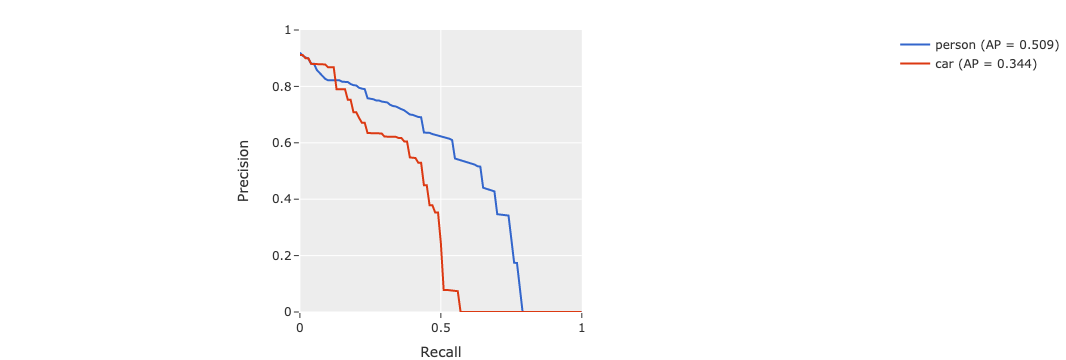

FigureWidget({
    'data': [{'customdata': array([0.99988198, 0.99976206, 0.99951147, 0.9986501 , 0.89960496, 0.89951644,
                                   0.89939888, 0.89922802, 0.89912866, 0.89890523, 0.89880363, 0.89853175,
                                   0.89828404, 0.89820041, 0.8979461 , 0.8976577 , 0.89749938, 0.89728618,
                                   0.89644278, 0.8958758 , 0.89509976, 0.8889141 , 0.88526444, 0.87643276,
                                   0.79657969, 0.79617561, 0.79541582, 0.79494855, 0.79427896, 0.79371219,
                                   0.79325874, 0.79228693, 0.79010382, 0.78802435, 0.78699406, 0.78525752,
                                   0.78358504, 0.78199387, 0.77871775, 0.7757645 , 0.77280099, 0.76468775,
                                   0.75996894, 0.75730504, 0.67831692, 0.67567982, 0.67354833, 0.66996306,
                                   0.66708532, 0.66099035, 0.65253912, 0.64910335, 0.6437327 , 0.6400404 ,
                      

In [23]:
plot = results.plot_pr_curves(classes=["person", "car"])
plot.show()

In [24]:
plot.freeze()  # replaces interactive plot with static image

### Sample-level analysis

The evaluation routine also populated some new fields on our dataset that contain helpful information that we can use to evaluate our predictions at the sample-level.

In particular, each sample now contains new fields:

- `eval_tp`: the number of true positive (TP) predictions in the sample
- `eval_fp`: the number of false positive (FP) predictions in the sample
- `eval_fn`: the number of false negative (FN) predictions in the sample

In [25]:
# Our dataset's schema now contains `eval_*` fields
print(dataset)

Name:        evaluate-detections-tutorial
Media type:  image
Num samples: 5000
Persistent:  True
Tags:        []
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    faster_rcnn:  fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    eval_tp:      fiftyone.core.fields.IntField
    eval_fp:      fiftyone.core.fields.IntField
    eval_fn:      fiftyone.core.fields.IntField


The individual predicted and ground truth objects also have fields populated on them describing the results of the matching process:

- `eval`: whether the object is a TP/FP/FN
- `eval_id`: the ID of the matching ground truth/predicted object, if any
- `eval_iou`: the IoU between the matching objects, if any

In [26]:
# Our detections have helpful evaluation data on them
sample = high_conf_view.first()
print(sample.faster_rcnn.detections[0])

<Detection: {
    'id': '66047b0f05c1282f3e986920',
    'attributes': {},
    'tags': [],
    'label': 'airplane',
    'bounding_box': [
        0.5629980087280273,
        0.7977214296832356,
        0.03478360176086426,
        0.1007584484383529,
    ],
    'mask': None,
    'confidence': 0.9952868223190308,
    'index': None,
    'eval_iou': 0.8995312552391188,
    'eval_id': '66047a4b05c1282f3e97f285',
    'eval': 'tp',
}>


These extra fields were added because we provided the ``eval_key`` parameter to [evaluate_detections()](https://voxel51.com/docs/fiftyone/api/fiftyone.core.collections.html#fiftyone.core.collections.SampleCollection.evaluate_detections). If we had omitted this parameter, then no information would have been recorded on our samples.

Don't worry, if you forget what evaluations you've run, you can retrieve information about the evaluation later:

In [27]:
print(dataset.list_evaluations())

['eval']


In [28]:
print(dataset.get_evaluation_info("eval"))

{
    "key": "eval",
    "version": "0.24.0",
    "timestamp": "2024-03-27T22:10:32.599000",
    "config": {
        "cls": "fiftyone.utils.eval.coco.COCOEvaluationConfig",
        "type": "detection",
        "method": "coco",
        "pred_field": "faster_rcnn",
        "gt_field": "ground_truth",
        "iou": 0.5,
        "classwise": true,
        "iscrowd": "iscrowd",
        "use_masks": false,
        "use_boxes": false,
        "tolerance": null,
        "compute_mAP": true,
        "iou_threshs": [
            0.5,
            0.55,
            0.6,
            0.65,
            0.7,
            0.75,
            0.8,
            0.85,
            0.9,
            0.95
        ],
        "max_preds": 100,
        "error_level": 1
    }
}


You can even load the view on which you ran an evaluation by calling the [load_evaluation_view()](https://voxel51.com/docs/fiftyone/api/fiftyone.core.collections.html?highlight=load_evaluation_view#fiftyone.core.collections.SampleCollection.load_evaluation_view) method on the parent dataset:

In [29]:
# Load the view on which we ran the `eval` evaluation
eval_view = dataset.load_evaluation_view("eval")
print(eval_view)

Dataset:     evaluate-detections-tutorial
Media type:  image
Num samples: 100
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    faster_rcnn:  fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    eval_tp:      fiftyone.core.fields.IntField
    eval_fp:      fiftyone.core.fields.IntField
    eval_fn:      fiftyone.core.fields.IntField
View stages:
    1. Take(size=100, seed=51)
    2. FilterLabels(field='faster_rcnn', filter={'$gt': ['$$this.confidence', 0.75]}, only_matches=False, trajectories=False)


Finally, you can delete an evaluation from a dataset, including any information that was added to your samples, by calling [delete_evaluation()](https://voxel51.com/docs/fiftyone/api/fiftyone.core.collections.html#fiftyone.core.collections.SampleCollection.delete_evaluation).

### Evaluation views

So, now that we have a sense for the aggregate performance of our model, let's dive into sample-level analysis by creating an [evaluation view](https://voxel51.com/docs/fiftyone/user_guide/app.html#viewing-evaluation-patches).

Any evaluation that you stored on your dataset can be used to generate an [evaluation view](https://voxel51.com/docs/fiftyone/user_guide/app.html#viewing-evaluation-patches) that is a patches view creating a sample for every true positive, false positive, and false negative in your dataset.
Through this view, you can quickly filter and sort evaluated detections by their type (TP/FP/FN), evaluated IoU, and if they are matched to a crowd object.

These evaluation views can be created through Python or directly in the App as shown below.

In [30]:
eval_patches = dataset.to_evaluation_patches("eval")
print(eval_patches)

Dataset:     evaluate-detections-tutorial
Media type:  image
Num patches: 37747
Patch fields:
    id:           fiftyone.core.fields.ObjectIdField
    sample_id:    fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    faster_rcnn:  fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    crowd:        fiftyone.core.fields.BooleanField
    type:         fiftyone.core.fields.StringField
    iou:          fiftyone.core.fields.FloatField
View stages:
    1. ToEvaluationPatches(eval_key='eval', config=None)


In [31]:
session.view = high_conf_view

![Evaluation Patches](images/evaluate_detections_eval_patches.gif)

Let's use this evaluation view to find individual false positive detections with a confidence of 0.85 or greater.

![FP Confidence Filter](images/evaluate_detections_high_conf_fp.gif)

### View the best-performing samples

To dig in further, let's create a view that sorts by `eval_tp` so we can see the best-performing cases of our model (i.e., the samples with the most correct predictions):

In [33]:
# Show samples with most true positives
session.view = high_conf_view.sort_by("eval_tp", reverse=True)

![Best Samples](images/evaluate_detections_eval_tp.jpg)

### View the worst-performing samples

Similarly, we can sort by the `eval_fp` field to see the worst-performing cases of our model (i.e., the samples with the most false positive predictions):

In [34]:
# Show samples with most false positives
session.view = high_conf_view.sort_by("eval_fp", reverse=True)

![Worst Samples](images/evaluate_detections_eval_fp.jpg)

### Filtering by bounding box area

[Dataset views](https://voxel51.com/docs/fiftyone/user_guide/using_views.html) are extremely powerful. For example, let's look at how our model performed on small objects by creating a view that contains only predictions whose bounding box area is less than `32^2` pixels:

In [37]:
# Compute metadata so we can reference image height/width in our view
dataset.compute_metadata()

In [38]:
#
# Create an expression that will match objects whose bounding boxes have
# area less than 32^2 pixels
#
# Bounding box format is [top-left-x, top-left-y, width, height]
# with relative coordinates in [0, 1], so we multiply by image
# dimensions to get pixel area
#
bbox_area = (
    F("$metadata.width") * F("bounding_box")[2] *
    F("$metadata.height") * F("bounding_box")[3]
)
small_boxes = bbox_area < 32 ** 2

# Create a view that contains only small (and high confidence) predictions
small_boxes_view = high_conf_view.filter_labels("faster_rcnn", small_boxes)

session.view = small_boxes_view

![Small Bboxes](images/evaluate_detections_small_bboxes.jpg)

We can always re-run evaluation to see how our detector fairs on only small boxes:

In [33]:
# Create a view that contains only small GT and predicted boxes
small_boxes_eval_view = (
    high_conf_view
    .filter_labels("ground_truth", small_boxes, only_matches=False)
    .filter_labels("faster_rcnn", small_boxes, only_matches=False)
)

# Run evaluation
small_boxes_results = small_boxes_eval_view.evaluate_detections(
    "faster_rcnn",
    gt_field="ground_truth",
)

Evaluating detections...
 100% |███████████████████| 34/34 [339.1ms elapsed, 0s remaining, 100.3 samples/s]     


In [34]:
# Get the 10 most common small object classes
small_counts = small_boxes_eval_view.count_values("ground_truth.detections.label")
classes_top10_small = sorted(small_counts, key=counts.get, reverse=True)[:10]

# Print a classification report for the top-10 small object classes
small_boxes_results.print_report(classes=classes_top10_small)

               precision    recall  f1-score   support

       person       0.66      0.44      0.53        80
          car       0.69      0.43      0.53        21
        chair       0.00      0.00      0.00         4
         book       0.00      0.00      0.00        20
       bottle       0.25      1.00      0.40         1
          cup       0.00      0.00      0.00         1
 dining table       0.00      0.00      0.00         2
traffic light       0.56      0.33      0.42        15
      handbag       0.00      0.00      0.00         7
         boat       0.00      0.00      0.00         1

    micro avg       0.61      0.33      0.43       152
    macro avg       0.22      0.22      0.19       152
 weighted avg       0.50      0.33      0.39       152



### Viewing detections in a crowd

If you're familiar with the [COCO data format](https://cocodataset.org/#format-data), you'll know that the ground truth annotations have an `iscrowd = 0/1` attribute that indicates whether a box contains multiple instances of the same object.

In [39]:
# View the `iscrowd` attribute on a ground truth object
sample = dataset.first()
print(sample.ground_truth.detections[0])

<Detection: {
    'id': '66047a4705c1282f3e97c5e9',
    'attributes': {},
    'tags': [],
    'label': 'potted plant',
    'bounding_box': [
        0.37028125,
        0.3345305164319249,
        0.038593749999999996,
        0.16314553990610328,
    ],
    'mask': None,
    'confidence': None,
    'index': None,
    'supercategory': 'furniture',
    'iscrowd': 0,
}>


Let's create a view that contains only samples with at least one detection for which `iscrowd` is 1:

In [40]:
# Create a view that contains only samples for which at least one detection has 
# its iscrowd attribute set to 1
crowded_images_view = high_conf_view.match(
    F("ground_truth.detections").filter(F("iscrowd") == 1).length() > 0
)

session.view = crowded_images_view

![Crowd Boxes](images/evaluate_detections_crowded.jpg)

### More complex insights

Let's combine our previous operations to form more complex queries that provide deeper insight into the quality of our detections.

For example, let's sort our view of crowded images from the previous section in decreasing order of false positive counts, so that we can see samples that have many (allegedly) spurious predictions in images that are known to contain crowds of objects:

In [41]:
session.view = crowded_images_view.sort_by("eval_fp", reverse=True)

![Crowd FPs](images/evaluate_detections_crowded_fp.jpg)

Let's compare the above view to another view that just sorts by false positive count, regardless of whether the image is crowded:

In [43]:
session.view = high_conf_view.sort_by("eval_fp", reverse=True)

![High Conf Eval FPs Sort](images/evaluate_detections_high_conf_eval_fp.jpg)

This was one of the first images in the view. As we can see, while the evaluation is detecting $7$ false positives, all of the model's predictions seem accurate. It is just that the ground truth labels lumped a bunch of orange slices together into one box.

**See anything interesting?**

What you find will likely be different because a random subset of samples were chosen. In our case, we find missing ground truth boxes for two of the laptop keyboards, a bottle, and even perhaps a cell phone. The model did not confidently predict many of the boxes in this image, but from a high-level, an example like this makes us consider the consequences of including complex or dense images in datasets. It will likely mean incorrect or incomplete ground truth annotations the annotators are not diligent! And that ultimately leads to confused models, and misinformed evaluations.

This conclusion would have been nearly impossible to achieve without visually inspecting the individual samples in the dataset according to the variety of criteria that we considered in this tutorial.

In [45]:
session.freeze()  # screenshot the active App for sharing

### Tagging and next steps

In practice, the next step is to take action on the issues that we identified above. A natural first step is to *tag* the issues so they can be retrieved and dealt with later. FiftyOne provides support for [tagging samples and labels](https://voxel51.com/docs/fiftyone/user_guide/app.html#tags-and-tagging), both programmatically and via the App.

In your App instance, try tagging the predictions with missing ground truth detections. You can do this by clicking on the boxes of the predictions of interest and using the tagging element in the top-right corner to assign a `possibly-missing` tag.

Alternatively, we can programmatically tag a batch of labels by creating a view that contains the objects of interest and then applying [tag_labels()](https://voxel51.com/docs/fiftyone/user_guide/fiftyone.core.collections.html?highlight=tag_labels#fiftyone.core.collections.SampleCollection.tag_labels):

In [44]:
# Tag all highly confident false positives as "possibly-missing"
(
    high_conf_view
        .filter_labels("faster_rcnn", F("eval") == "fp")
        .select_fields("faster_rcnn")
        .tag_labels("possibly-missing")
)

These tagged labels could then be sent off to our annotation provider of choice for review and addition to the ground truth labels. FiftyOne currently offers integrations for [Scale AI](https://voxel51.com/docs/fiftyone/api/fiftyone.utils.scale.html), [Labelbox](https://voxel51.com/docs/fiftyone/api/fiftyone.utils.labelbox.html), and [CVAT](https://voxel51.com/docs/fiftyone/api/fiftyone.types.dataset_types.html?highlight=cvat#fiftyone.types.dataset_types.CVATImageDataset).

For example, the snippet below exports the tagged labels and their source media to disk in CVAT format:

In [ ]:
# Export all labels with the `possibly-missing` tag in CVAT format
(
    dataset
        .select_labels(tags=["possibly-missing"])
        .export("/path/for/export", fo.types.CVATImageDataset)
)

## Summary

In this tutorial, we covered loading a dataset into FiftyOne and analyzing the performance of an out-of-the-box object detection model on the dataset.

**So, what's the takeaway?**

Aggregate evaluation results for an object detector are important, but they alone don't tell the whole story of a model's performance. It's critical to study the failure modes of your model so you can take the right actions to improve them.

In this tutorial, we covered two types of analysis:

- Analyzing the performance of your detector across different strata, like high confidence, small objects in crowded scenes
- Inspecting the hardest samples in your dataset to diagnose the underlying issue, whether it be your detector or the ground truth annotations